In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
dataset = pd.read_csv('../../data/TFT_energy.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,pressure_Bilbao,...,wind_deg_Bilbao,clouds_all_Bilbao,gen_hyd_river,wind_deg_Seville,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,...,229.0,0.0,1009.0,21.0,7.0,1.0,0.0,5890.0,1.0,920.0
2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,...,224.0,0.0,973.0,27.0,7.0,0.0,1.0,5461.0,1.0,1164.0
2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,...,225.0,0.0,949.0,27.0,7.0,0.0,1.0,5238.0,1.0,1503.0
2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,...,221.0,0.0,953.0,27.0,7.0,0.0,1.0,4935.0,1.0,1826.0
2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,...,224.0,0.0,952.0,57.0,5.0,2.0,1.0,4618.0,0.0,2109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,1033.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
2018-12-31 19:00:00+00:00,76.16,68.40,2566.0,7241.0,29735.0,0.0,174.0,95.0,1027.0,1034.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
2018-12-31 20:00:00+00:00,74.30,66.88,2422.0,7025.0,28071.0,0.0,168.0,94.0,1028.0,1034.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0


In [4]:
print(dataset.columns)

Index(['price', 'price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['price']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (35063, 1)
stages_supervised.shape: (34968, 96)


In [7]:
stages.max()

price    116.8
dtype: float64

In [8]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
time,,,,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00+00:00,64.92,64.48,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,...,52.07,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77
2015-01-04 01:00:00+00:00,64.48,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,...,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89
2015-01-04 02:00:00+00:00,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,...,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91
2015-01-04 03:00:00+00:00,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,62.05,...,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68
2015-01-04 04:00:00+00:00,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,62.05,62.06,...,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68,58.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30 19:00:00+00:00,78.99,77.65,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,...,72.12,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02
2018-12-30 20:00:00+00:00,77.65,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,64.27,...,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16
2018-12-30 21:00:00+00:00,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,64.27,66.81,...,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30


#### Prior unknown covariates (6)

In [9]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [10]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [11]:
prior_known = dataset[['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (35063, 25)
prior_known_supervised.shape: (34968, 2400)


In [12]:
# prior_known_supervised

### N_out, N_in, K

In [13]:
past_cov = dataset[['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (34968, 2400)


In [14]:
# past_cov_supervised  # 6 + 9 = 15 features

In [15]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [16]:
# past_ws_supervised  # 4

In [17]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [18]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [19]:
# past_cov_ws_supervised

In [20]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var10(t-48),...,shift_prior_known_supervised_var16(t+23),shift_prior_known_supervised_var17(t+23),shift_prior_known_supervised_var18(t+23),shift_prior_known_supervised_var19(t+23),shift_prior_known_supervised_var20(t+23),shift_prior_known_supervised_var21(t+23),shift_prior_known_supervised_var22(t+23),shift_prior_known_supervised_var23(t+23),shift_prior_known_supervised_var24(t+23),shift_prior_known_supervised_var25(t+23)
0,7.00,1190.0,2902.0,24935.0,0.0,192.0,61.0,1038.0,1036.0,167.0,...,156.0,21.0,1182.0,132.0,2.0,1.0,0.0,7351.0,1.0,650.0
1,5.00,1023.0,2772.0,23214.0,0.0,189.0,60.0,1037.0,1036.0,167.0,...,163.0,12.0,1099.0,132.0,1.0,1.0,0.0,7403.0,1.0,938.0
2,4.00,1016.0,2936.0,22540.0,0.0,188.0,59.0,1037.0,1036.0,181.0,...,160.0,13.0,1076.0,108.0,2.0,2.0,0.0,7887.0,1.0,1021.0
3,4.00,1103.0,2893.0,22096.0,0.0,189.0,61.0,1037.0,1037.0,181.0,...,165.0,6.0,982.0,108.0,1.0,2.0,0.0,8348.0,1.0,2067.0
4,4.80,1120.0,2889.0,22066.0,0.0,190.0,59.0,1038.0,1037.0,171.0,...,162.0,20.0,982.0,108.0,1.0,2.0,0.0,8348.0,1.0,2067.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,66.00,2931.0,9149.0,32642.0,718.0,294.0,103.0,1028.0,1033.0,314.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
34964,62.09,2889.0,8024.0,32155.0,675.0,294.0,103.0,1028.0,1033.0,315.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
34965,61.77,2871.0,6871.0,30428.0,569.0,291.0,104.0,1029.0,1033.0,314.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0
34966,58.43,2619.0,5822.0,28015.0,310.0,288.0,103.0,1029.0,1033.0,313.0,...,120.0,0.0,1128.0,60.0,5.0,2.0,1.0,3586.0,2.0,108.0


In [21]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
                                                     axis=1)


In [22]:
# shift_prior_known_past_cov_ws_supervised

In [23]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
0,50.54,48.68,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,...,52.07,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77
1,48.68,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,...,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89
2,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,...,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91
3,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,59.22,...,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68
4,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,59.22,58.56,...,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68,58.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,73.35,73.64,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,...,72.12,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02
34964,73.64,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,...,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16
34965,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,60.70,...,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30
34966,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,60.70,66.64,...,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30,69.89


### Concatenation

In [24]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (34968, 3696)


### Train & Test set

In [25]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 27974


In [26]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

3672

### Normalization

In [27]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (27974, 3672) (27974, 24) (6994, 3672) (6994, 24)


In [28]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (27974, 72, 51) (27974, 24) (6994, 72, 51) (6994, 24)


### Model

In [68]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))
x = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)
x = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = layers.Conv1D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = layers.Conv1D(filters=32, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)

x = layers.Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(train_y.shape[1])(x)

energy_pararcnn = Model(model_input, x)
energy_pararcnn.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 72, 51)]          0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 72, 256)           26368     
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 72, 128)           65664     
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 72, 64)            16448     
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 72, 32)            4128      
_________________________________________________________________
flatten_10 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               590

Epoch 1/6000

Epoch 00001: val_mae improved from inf to 0.20950, saving model to saved_model/energy_cnn_sc1_4layer_24h_no_sc.h5
55/55 - 2s - loss: 0.2350 - mae: 0.1411 - val_loss: 0.2095 - val_mae: 0.2095
Epoch 2/6000

Epoch 00002: val_mae improved from 0.20950 to 0.14101, saving model to saved_model/energy_cnn_sc1_4layer_24h_no_sc.h5
55/55 - 1s - loss: 0.1412 - mae: 0.0779 - val_loss: 0.1377 - val_mae: 0.1410
Epoch 3/6000

Epoch 00003: val_mae improved from 0.14101 to 0.13450, saving model to saved_model/energy_cnn_sc1_4layer_24h_no_sc.h5
55/55 - 1s - loss: 0.1085 - mae: 0.0691 - val_loss: 0.1137 - val_mae: 0.1345
Epoch 4/6000

Epoch 00004: val_mae improved from 0.13450 to 0.09570, saving model to saved_model/energy_cnn_sc1_4layer_24h_no_sc.h5
55/55 - 1s - loss: 0.0899 - mae: 0.0643 - val_loss: 0.0890 - val_mae: 0.0957
Epoch 5/6000

Epoch 00005: val_mae did not improve from 0.09570
55/55 - 1s - loss: 0.0767 - mae: 0.0593 - val_loss: 0.0815 - val_mae: 0.1083
Epoch 6/6000

Epoch 00006: 

Epoch 54/6000

Epoch 00054: val_mae did not improve from 0.04975
55/55 - 1s - loss: 0.0114 - mae: 0.0430 - val_loss: 0.0132 - val_mae: 0.0569
Epoch 55/6000

Epoch 00055: val_mae did not improve from 0.04975
55/55 - 1s - loss: 0.0113 - mae: 0.0431 - val_loss: 0.0130 - val_mae: 0.0565
Epoch 56/6000

Epoch 00056: val_mae did not improve from 0.04975
55/55 - 1s - loss: 0.0111 - mae: 0.0429 - val_loss: 0.0130 - val_mae: 0.0579
Epoch 57/6000

Epoch 00057: val_mae did not improve from 0.04975
55/55 - 1s - loss: 0.0109 - mae: 0.0431 - val_loss: 0.0120 - val_mae: 0.0515
Epoch 58/6000

Epoch 00058: val_mae did not improve from 0.04975
55/55 - 1s - loss: 0.0108 - mae: 0.0435 - val_loss: 0.0120 - val_mae: 0.0523
Epoch 59/6000

Epoch 00059: val_mae did not improve from 0.04975
55/55 - 1s - loss: 0.0107 - mae: 0.0434 - val_loss: 0.0122 - val_mae: 0.0553
Epoch 60/6000

Epoch 00060: val_mae did not improve from 0.04975
55/55 - 1s - loss: 0.0105 - mae: 0.0435 - val_loss: 0.0125 - val_mae: 0.0586
Epoch 

Epoch 111/6000

Epoch 00111: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0067 - mae: 0.0420 - val_loss: 0.0086 - val_mae: 0.0561
Epoch 112/6000

Epoch 00112: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0067 - mae: 0.0420 - val_loss: 0.0099 - val_mae: 0.0649
Epoch 113/6000

Epoch 00113: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0066 - mae: 0.0421 - val_loss: 0.0078 - val_mae: 0.0505
Epoch 114/6000

Epoch 00114: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0066 - mae: 0.0418 - val_loss: 0.0087 - val_mae: 0.0571
Epoch 115/6000

Epoch 00115: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0065 - mae: 0.0418 - val_loss: 0.0081 - val_mae: 0.0537
Epoch 116/6000

Epoch 00116: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0066 - mae: 0.0422 - val_loss: 0.0083 - val_mae: 0.0551
Epoch 117/6000

Epoch 00117: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0065 - mae: 0.0417 - val_loss: 0.0079 - val_mae: 0.0519

Epoch 169/6000

Epoch 00169: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0056 - mae: 0.0415 - val_loss: 0.0070 - val_mae: 0.0512
Epoch 170/6000

Epoch 00170: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0056 - mae: 0.0415 - val_loss: 0.0078 - val_mae: 0.0575
Epoch 171/6000

Epoch 00171: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0055 - mae: 0.0413 - val_loss: 0.0074 - val_mae: 0.0544
Epoch 172/6000

Epoch 00172: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0055 - mae: 0.0411 - val_loss: 0.0075 - val_mae: 0.0556
Epoch 173/6000

Epoch 00173: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0055 - mae: 0.0409 - val_loss: 0.0079 - val_mae: 0.0583
Epoch 174/6000

Epoch 00174: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0055 - mae: 0.0413 - val_loss: 0.0073 - val_mae: 0.0537
Epoch 175/6000

Epoch 00175: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0055 - mae: 0.0414 - val_loss: 0.0078 - val_mae: 0.0578

Epoch 227/6000

Epoch 00227: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0051 - mae: 0.0408 - val_loss: 0.0075 - val_mae: 0.0577
Epoch 228/6000

Epoch 00228: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0051 - mae: 0.0405 - val_loss: 0.0073 - val_mae: 0.0567
Epoch 229/6000

Epoch 00229: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0052 - mae: 0.0412 - val_loss: 0.0066 - val_mae: 0.0511
Epoch 230/6000

Epoch 00230: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0051 - mae: 0.0407 - val_loss: 0.0071 - val_mae: 0.0549
Epoch 231/6000

Epoch 00231: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0051 - mae: 0.0405 - val_loss: 0.0072 - val_mae: 0.0556
Epoch 232/6000

Epoch 00232: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0051 - mae: 0.0405 - val_loss: 0.0071 - val_mae: 0.0554
Epoch 233/6000

Epoch 00233: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0050 - mae: 0.0404 - val_loss: 0.0068 - val_mae: 0.0530

Epoch 285/6000

Epoch 00285: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0049 - mae: 0.0404 - val_loss: 0.0061 - val_mae: 0.0493
Epoch 286/6000

Epoch 00286: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0048 - mae: 0.0403 - val_loss: 0.0063 - val_mae: 0.0507
Epoch 287/6000

Epoch 00287: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0048 - mae: 0.0401 - val_loss: 0.0068 - val_mae: 0.0546
Epoch 288/6000

Epoch 00288: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0048 - mae: 0.0401 - val_loss: 0.0064 - val_mae: 0.0514
Epoch 289/6000

Epoch 00289: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0048 - mae: 0.0401 - val_loss: 0.0067 - val_mae: 0.0540
Epoch 290/6000

Epoch 00290: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0048 - mae: 0.0402 - val_loss: 0.0064 - val_mae: 0.0518
Epoch 291/6000

Epoch 00291: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0048 - mae: 0.0401 - val_loss: 0.0065 - val_mae: 0.0523

Epoch 343/6000

Epoch 00343: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0046 - mae: 0.0397 - val_loss: 0.0062 - val_mae: 0.0508
Epoch 344/6000

Epoch 00344: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0046 - mae: 0.0398 - val_loss: 0.0062 - val_mae: 0.0516
Epoch 345/6000

Epoch 00345: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0046 - mae: 0.0397 - val_loss: 0.0062 - val_mae: 0.0513
Epoch 346/6000

Epoch 00346: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0046 - mae: 0.0397 - val_loss: 0.0063 - val_mae: 0.0522
Epoch 347/6000

Epoch 00347: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0046 - mae: 0.0397 - val_loss: 0.0061 - val_mae: 0.0502
Epoch 348/6000

Epoch 00348: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0046 - mae: 0.0399 - val_loss: 0.0065 - val_mae: 0.0533
Epoch 349/6000

Epoch 00349: val_mae did not improve from 0.04926
55/55 - 1s - loss: 0.0046 - mae: 0.0398 - val_loss: 0.0068 - val_mae: 0.0561

Epoch 400/6000

Epoch 00400: val_mae did not improve from 0.04854
55/55 - 1s - loss: 0.0045 - mae: 0.0395 - val_loss: 0.0060 - val_mae: 0.0503
Epoch 401/6000

Epoch 00401: val_mae did not improve from 0.04854
55/55 - 1s - loss: 0.0045 - mae: 0.0396 - val_loss: 0.0063 - val_mae: 0.0526
Epoch 402/6000

Epoch 00402: val_mae did not improve from 0.04854
55/55 - 1s - loss: 0.0045 - mae: 0.0397 - val_loss: 0.0063 - val_mae: 0.0528
Epoch 403/6000

Epoch 00403: val_mae did not improve from 0.04854
55/55 - 1s - loss: 0.0045 - mae: 0.0395 - val_loss: 0.0063 - val_mae: 0.0525
Epoch 404/6000

Epoch 00404: val_mae did not improve from 0.04854
55/55 - 1s - loss: 0.0045 - mae: 0.0394 - val_loss: 0.0061 - val_mae: 0.0511
Epoch 405/6000

Epoch 00405: val_mae did not improve from 0.04854
55/55 - 1s - loss: 0.0045 - mae: 0.0394 - val_loss: 0.0064 - val_mae: 0.0531
Epoch 406/6000

Epoch 00406: val_mae did not improve from 0.04854
55/55 - 1s - loss: 0.0045 - mae: 0.0395 - val_loss: 0.0063 - val_mae: 0.0528

Epoch 458/6000

Epoch 00458: val_mae did not improve from 0.04854
55/55 - 1s - loss: 0.0044 - mae: 0.0395 - val_loss: 0.0064 - val_mae: 0.0536
Epoch 459/6000

Epoch 00459: val_mae did not improve from 0.04854
55/55 - 1s - loss: 0.0044 - mae: 0.0394 - val_loss: 0.0059 - val_mae: 0.0502
Epoch 460/6000

Epoch 00460: val_mae did not improve from 0.04854
55/55 - 1s - loss: 0.0044 - mae: 0.0390 - val_loss: 0.0062 - val_mae: 0.0516
Epoch 461/6000

Epoch 00461: val_mae did not improve from 0.04854
55/55 - 1s - loss: 0.0045 - mae: 0.0397 - val_loss: 0.0082 - val_mae: 0.0657
Epoch 462/6000

Epoch 00462: val_mae did not improve from 0.04854
55/55 - 1s - loss: 0.0044 - mae: 0.0395 - val_loss: 0.0065 - val_mae: 0.0544
Epoch 463/6000

Epoch 00463: val_mae did not improve from 0.04854
55/55 - 1s - loss: 0.0044 - mae: 0.0392 - val_loss: 0.0067 - val_mae: 0.0556
Epoch 464/6000

Epoch 00464: val_mae improved from 0.04854 to 0.04853, saving model to saved_model/energy_cnn_sc1_4layer_24h_no_sc.h5
55/55 - 

Epoch 514/6000

Epoch 00514: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0044 - mae: 0.0391 - val_loss: 0.0064 - val_mae: 0.0536
Epoch 515/6000

Epoch 00515: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0044 - mae: 0.0393 - val_loss: 0.0057 - val_mae: 0.0483
Epoch 516/6000

Epoch 00516: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0043 - mae: 0.0389 - val_loss: 0.0058 - val_mae: 0.0492
Epoch 517/6000

Epoch 00517: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0043 - mae: 0.0390 - val_loss: 0.0062 - val_mae: 0.0524
Epoch 518/6000

Epoch 00518: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0043 - mae: 0.0389 - val_loss: 0.0066 - val_mae: 0.0554
Epoch 519/6000

Epoch 00519: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0043 - mae: 0.0387 - val_loss: 0.0058 - val_mae: 0.0492
Epoch 520/6000

Epoch 00520: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0043 - mae: 0.0388 - val_loss: 0.0061 - val_mae: 0.0519

Epoch 572/6000

Epoch 00572: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0043 - mae: 0.0386 - val_loss: 0.0063 - val_mae: 0.0532
Epoch 573/6000

Epoch 00573: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0043 - mae: 0.0387 - val_loss: 0.0060 - val_mae: 0.0510
Epoch 574/6000

Epoch 00574: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0043 - mae: 0.0387 - val_loss: 0.0061 - val_mae: 0.0515
Epoch 575/6000

Epoch 00575: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0043 - mae: 0.0387 - val_loss: 0.0058 - val_mae: 0.0494
Epoch 576/6000

Epoch 00576: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0043 - mae: 0.0390 - val_loss: 0.0059 - val_mae: 0.0505
Epoch 577/6000

Epoch 00577: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0043 - mae: 0.0386 - val_loss: 0.0060 - val_mae: 0.0510
Epoch 578/6000

Epoch 00578: val_mae did not improve from 0.04790
55/55 - 1s - loss: 0.0043 - mae: 0.0386 - val_loss: 0.0059 - val_mae: 0.0503

Epoch 630/6000

Epoch 00630: val_mae improved from 0.04790 to 0.04767, saving model to saved_model/energy_cnn_sc1_4layer_24h_no_sc.h5
55/55 - 1s - loss: 0.0042 - mae: 0.0384 - val_loss: 0.0055 - val_mae: 0.0477
Epoch 631/6000

Epoch 00631: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0042 - mae: 0.0384 - val_loss: 0.0061 - val_mae: 0.0522
Epoch 632/6000

Epoch 00632: val_mae did not improve from 0.04767
55/55 - 2s - loss: 0.0042 - mae: 0.0385 - val_loss: 0.0058 - val_mae: 0.0501
Epoch 633/6000

Epoch 00633: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0042 - mae: 0.0384 - val_loss: 0.0057 - val_mae: 0.0491
Epoch 634/6000

Epoch 00634: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0043 - mae: 0.0389 - val_loss: 0.0060 - val_mae: 0.0516
Epoch 635/6000

Epoch 00635: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0042 - mae: 0.0386 - val_loss: 0.0062 - val_mae: 0.0527
Epoch 636/6000

Epoch 00636: val_mae did not improve from 0.04767
55/55 - 

Epoch 687/6000

Epoch 00687: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0042 - mae: 0.0382 - val_loss: 0.0062 - val_mae: 0.0529
Epoch 688/6000

Epoch 00688: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0042 - mae: 0.0386 - val_loss: 0.0057 - val_mae: 0.0494
Epoch 689/6000

Epoch 00689: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0042 - mae: 0.0383 - val_loss: 0.0061 - val_mae: 0.0526
Epoch 690/6000

Epoch 00690: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0041 - mae: 0.0382 - val_loss: 0.0059 - val_mae: 0.0512
Epoch 691/6000

Epoch 00691: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0041 - mae: 0.0382 - val_loss: 0.0058 - val_mae: 0.0498
Epoch 692/6000

Epoch 00692: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0042 - mae: 0.0384 - val_loss: 0.0059 - val_mae: 0.0509
Epoch 693/6000

Epoch 00693: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0041 - mae: 0.0382 - val_loss: 0.0062 - val_mae: 0.0533

Epoch 745/6000

Epoch 00745: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0042 - mae: 0.0385 - val_loss: 0.0061 - val_mae: 0.0523
Epoch 746/6000

Epoch 00746: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0041 - mae: 0.0382 - val_loss: 0.0056 - val_mae: 0.0487
Epoch 747/6000

Epoch 00747: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0041 - mae: 0.0385 - val_loss: 0.0062 - val_mae: 0.0527
Epoch 748/6000

Epoch 00748: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0041 - mae: 0.0381 - val_loss: 0.0061 - val_mae: 0.0521
Epoch 749/6000

Epoch 00749: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0041 - mae: 0.0379 - val_loss: 0.0063 - val_mae: 0.0534
Epoch 750/6000

Epoch 00750: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0041 - mae: 0.0381 - val_loss: 0.0061 - val_mae: 0.0520
Epoch 751/6000

Epoch 00751: val_mae did not improve from 0.04767
55/55 - 1s - loss: 0.0041 - mae: 0.0381 - val_loss: 0.0059 - val_mae: 0.0507

Epoch 802/6000

Epoch 00802: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0041 - mae: 0.0381 - val_loss: 0.0058 - val_mae: 0.0500
Epoch 803/6000

Epoch 00803: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0041 - mae: 0.0386 - val_loss: 0.0060 - val_mae: 0.0515
Epoch 804/6000

Epoch 00804: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0041 - mae: 0.0380 - val_loss: 0.0058 - val_mae: 0.0501
Epoch 805/6000

Epoch 00805: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0378 - val_loss: 0.0061 - val_mae: 0.0530
Epoch 806/6000

Epoch 00806: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0042 - mae: 0.0388 - val_loss: 0.0057 - val_mae: 0.0496
Epoch 807/6000

Epoch 00807: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0041 - mae: 0.0383 - val_loss: 0.0056 - val_mae: 0.0489
Epoch 808/6000

Epoch 00808: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0041 - mae: 0.0381 - val_loss: 0.0059 - val_mae: 0.0511

Epoch 860/6000

Epoch 00860: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0377 - val_loss: 0.0059 - val_mae: 0.0511
Epoch 861/6000

Epoch 00861: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0378 - val_loss: 0.0062 - val_mae: 0.0529
Epoch 862/6000

Epoch 00862: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0378 - val_loss: 0.0063 - val_mae: 0.0539
Epoch 863/6000

Epoch 00863: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0378 - val_loss: 0.0057 - val_mae: 0.0499
Epoch 864/6000

Epoch 00864: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0380 - val_loss: 0.0061 - val_mae: 0.0524
Epoch 865/6000

Epoch 00865: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0379 - val_loss: 0.0055 - val_mae: 0.0478
Epoch 866/6000

Epoch 00866: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0376 - val_loss: 0.0056 - val_mae: 0.0487

Epoch 918/6000

Epoch 00918: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0382 - val_loss: 0.0058 - val_mae: 0.0502
Epoch 919/6000

Epoch 00919: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0375 - val_loss: 0.0062 - val_mae: 0.0533
Epoch 920/6000

Epoch 00920: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0378 - val_loss: 0.0062 - val_mae: 0.0533
Epoch 921/6000

Epoch 00921: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0376 - val_loss: 0.0058 - val_mae: 0.0504
Epoch 922/6000

Epoch 00922: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0378 - val_loss: 0.0056 - val_mae: 0.0490
Epoch 923/6000

Epoch 00923: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0377 - val_loss: 0.0057 - val_mae: 0.0496
Epoch 924/6000

Epoch 00924: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0376 - val_loss: 0.0062 - val_mae: 0.0530

Epoch 976/6000

Epoch 00976: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0377 - val_loss: 0.0061 - val_mae: 0.0526
Epoch 977/6000

Epoch 00977: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0378 - val_loss: 0.0061 - val_mae: 0.0527
Epoch 978/6000

Epoch 00978: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0375 - val_loss: 0.0064 - val_mae: 0.0548
Epoch 979/6000

Epoch 00979: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0377 - val_loss: 0.0062 - val_mae: 0.0536
Epoch 980/6000

Epoch 00980: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0377 - val_loss: 0.0058 - val_mae: 0.0506
Epoch 981/6000

Epoch 00981: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0040 - mae: 0.0378 - val_loss: 0.0069 - val_mae: 0.0583
Epoch 982/6000

Epoch 00982: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0376 - val_loss: 0.0061 - val_mae: 0.0528


Epoch 01033: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0373 - val_loss: 0.0064 - val_mae: 0.0547
Epoch 1034/6000

Epoch 01034: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0374 - val_loss: 0.0061 - val_mae: 0.0532
Epoch 1035/6000

Epoch 01035: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0378 - val_loss: 0.0068 - val_mae: 0.0576
Epoch 1036/6000

Epoch 01036: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0375 - val_loss: 0.0060 - val_mae: 0.0523
Epoch 1037/6000

Epoch 01037: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0376 - val_loss: 0.0057 - val_mae: 0.0497
Epoch 1038/6000

Epoch 01038: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0375 - val_loss: 0.0057 - val_mae: 0.0497
Epoch 1039/6000

Epoch 01039: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0373 - val_loss: 0.0064 - val_mae: 0.0548
Epoch 10


Epoch 01090: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0374 - val_loss: 0.0060 - val_mae: 0.0523
Epoch 1091/6000

Epoch 01091: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0376 - val_loss: 0.0056 - val_mae: 0.0495
Epoch 1092/6000

Epoch 01092: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0373 - val_loss: 0.0062 - val_mae: 0.0538
Epoch 1093/6000

Epoch 01093: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0373 - val_loss: 0.0059 - val_mae: 0.0518
Epoch 1094/6000

Epoch 01094: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0372 - val_loss: 0.0063 - val_mae: 0.0542
Epoch 1095/6000

Epoch 01095: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0373 - val_loss: 0.0057 - val_mae: 0.0502
Epoch 1096/6000

Epoch 01096: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0371 - val_loss: 0.0057 - val_mae: 0.0504
Epoch 10


Epoch 01147: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0373 - val_loss: 0.0060 - val_mae: 0.0524
Epoch 1148/6000

Epoch 01148: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0374 - val_loss: 0.0056 - val_mae: 0.0494
Epoch 1149/6000

Epoch 01149: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0373 - val_loss: 0.0058 - val_mae: 0.0508
Epoch 1150/6000

Epoch 01150: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0372 - val_loss: 0.0061 - val_mae: 0.0527
Epoch 1151/6000

Epoch 01151: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0372 - val_loss: 0.0058 - val_mae: 0.0505
Epoch 1152/6000

Epoch 01152: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0374 - val_loss: 0.0058 - val_mae: 0.0509
Epoch 1153/6000

Epoch 01153: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0373 - val_loss: 0.0069 - val_mae: 0.0587
Epoch 11


Epoch 01204: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0371 - val_loss: 0.0064 - val_mae: 0.0553
Epoch 1205/6000

Epoch 01205: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0372 - val_loss: 0.0062 - val_mae: 0.0542
Epoch 1206/6000

Epoch 01206: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0374 - val_loss: 0.0063 - val_mae: 0.0542
Epoch 1207/6000

Epoch 01207: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0374 - val_loss: 0.0058 - val_mae: 0.0509
Epoch 1208/6000

Epoch 01208: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0373 - val_loss: 0.0061 - val_mae: 0.0531
Epoch 1209/6000

Epoch 01209: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0374 - val_loss: 0.0059 - val_mae: 0.0518
Epoch 1210/6000

Epoch 01210: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0373 - val_loss: 0.0061 - val_mae: 0.0528
Epoch 12


Epoch 01261: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0374 - val_loss: 0.0061 - val_mae: 0.0530
Epoch 1262/6000

Epoch 01262: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0371 - val_loss: 0.0059 - val_mae: 0.0515
Epoch 1263/6000

Epoch 01263: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0373 - val_loss: 0.0061 - val_mae: 0.0534
Epoch 1264/6000

Epoch 01264: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0373 - val_loss: 0.0058 - val_mae: 0.0510
Epoch 1265/6000

Epoch 01265: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0371 - val_loss: 0.0063 - val_mae: 0.0548
Epoch 1266/6000

Epoch 01266: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0373 - val_loss: 0.0066 - val_mae: 0.0562
Epoch 1267/6000

Epoch 01267: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0373 - val_loss: 0.0063 - val_mae: 0.0544
Epoch 12


Epoch 01318: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0372 - val_loss: 0.0069 - val_mae: 0.0584
Epoch 1319/6000

Epoch 01319: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0373 - val_loss: 0.0057 - val_mae: 0.0504
Epoch 1320/6000

Epoch 01320: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0373 - val_loss: 0.0060 - val_mae: 0.0526
Epoch 1321/6000

Epoch 01321: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0039 - mae: 0.0377 - val_loss: 0.0055 - val_mae: 0.0488
Epoch 1322/6000

Epoch 01322: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0373 - val_loss: 0.0068 - val_mae: 0.0582
Epoch 1323/6000

Epoch 01323: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0369 - val_loss: 0.0058 - val_mae: 0.0506
Epoch 1324/6000

Epoch 01324: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0369 - val_loss: 0.0064 - val_mae: 0.0550
Epoch 13


Epoch 01375: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0374 - val_loss: 0.0063 - val_mae: 0.0543
Epoch 1376/6000

Epoch 01376: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0369 - val_loss: 0.0060 - val_mae: 0.0522
Epoch 1377/6000

Epoch 01377: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0372 - val_loss: 0.0069 - val_mae: 0.0585
Epoch 1378/6000

Epoch 01378: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0371 - val_loss: 0.0062 - val_mae: 0.0536
Epoch 1379/6000

Epoch 01379: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0371 - val_loss: 0.0062 - val_mae: 0.0537
Epoch 1380/6000

Epoch 01380: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0372 - val_loss: 0.0062 - val_mae: 0.0535
Epoch 1381/6000

Epoch 01381: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0371 - val_loss: 0.0058 - val_mae: 0.0507
Epoch 13


Epoch 01432: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0374 - val_loss: 0.0062 - val_mae: 0.0536
Epoch 1433/6000

Epoch 01433: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0369 - val_loss: 0.0068 - val_mae: 0.0581
Epoch 1434/6000

Epoch 01434: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0374 - val_loss: 0.0065 - val_mae: 0.0562
Epoch 1435/6000

Epoch 01435: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0369 - val_loss: 0.0060 - val_mae: 0.0525
Epoch 1436/6000

Epoch 01436: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0370 - val_loss: 0.0063 - val_mae: 0.0546
Epoch 1437/6000

Epoch 01437: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0374 - val_loss: 0.0067 - val_mae: 0.0578
Epoch 1438/6000

Epoch 01438: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0370 - val_loss: 0.0064 - val_mae: 0.0551
Epoch 14


Epoch 01489: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0371 - val_loss: 0.0062 - val_mae: 0.0540
Epoch 1490/6000

Epoch 01490: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0370 - val_loss: 0.0063 - val_mae: 0.0540
Epoch 1491/6000

Epoch 01491: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0374 - val_loss: 0.0071 - val_mae: 0.0597
Epoch 1492/6000

Epoch 01492: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0372 - val_loss: 0.0065 - val_mae: 0.0556
Epoch 1493/6000

Epoch 01493: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0374 - val_loss: 0.0074 - val_mae: 0.0617
Epoch 1494/6000

Epoch 01494: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0370 - val_loss: 0.0059 - val_mae: 0.0517
Epoch 1495/6000

Epoch 01495: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0370 - val_loss: 0.0063 - val_mae: 0.0543
Epoch 14


Epoch 01546: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0370 - val_loss: 0.0065 - val_mae: 0.0563
Epoch 1547/6000

Epoch 01547: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0370 - val_loss: 0.0062 - val_mae: 0.0538
Epoch 1548/6000

Epoch 01548: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0368 - val_loss: 0.0061 - val_mae: 0.0531
Epoch 1549/6000

Epoch 01549: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0371 - val_loss: 0.0066 - val_mae: 0.0563
Epoch 1550/6000

Epoch 01550: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0373 - val_loss: 0.0060 - val_mae: 0.0522
Epoch 1551/6000

Epoch 01551: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0370 - val_loss: 0.0059 - val_mae: 0.0517
Epoch 1552/6000

Epoch 01552: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0369 - val_loss: 0.0071 - val_mae: 0.0599
Epoch 15


Epoch 01603: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0369 - val_loss: 0.0066 - val_mae: 0.0564
Epoch 1604/6000

Epoch 01604: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0373 - val_loss: 0.0061 - val_mae: 0.0533
Epoch 1605/6000

Epoch 01605: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0367 - val_loss: 0.0062 - val_mae: 0.0536
Epoch 1606/6000

Epoch 01606: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0369 - val_loss: 0.0061 - val_mae: 0.0534
Epoch 1607/6000

Epoch 01607: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0369 - val_loss: 0.0063 - val_mae: 0.0542
Epoch 1608/6000

Epoch 01608: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0367 - val_loss: 0.0068 - val_mae: 0.0578
Epoch 1609/6000

Epoch 01609: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0369 - val_loss: 0.0058 - val_mae: 0.0509
Epoch 16


Epoch 01660: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0368 - val_loss: 0.0064 - val_mae: 0.0551
Epoch 1661/6000

Epoch 01661: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0368 - val_loss: 0.0062 - val_mae: 0.0539
Epoch 1662/6000

Epoch 01662: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0368 - val_loss: 0.0072 - val_mae: 0.0605
Epoch 1663/6000

Epoch 01663: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0369 - val_loss: 0.0066 - val_mae: 0.0565
Epoch 1664/6000

Epoch 01664: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0372 - val_loss: 0.0060 - val_mae: 0.0522
Epoch 1665/6000

Epoch 01665: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0370 - val_loss: 0.0059 - val_mae: 0.0514
Epoch 1666/6000

Epoch 01666: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0368 - val_loss: 0.0062 - val_mae: 0.0536
Epoch 16


Epoch 01717: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0370 - val_loss: 0.0063 - val_mae: 0.0549
Epoch 1718/6000

Epoch 01718: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0366 - val_loss: 0.0072 - val_mae: 0.0606
Epoch 1719/6000

Epoch 01719: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0038 - mae: 0.0371 - val_loss: 0.0064 - val_mae: 0.0552
Epoch 1720/6000

Epoch 01720: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0370 - val_loss: 0.0062 - val_mae: 0.0536
Epoch 1721/6000

Epoch 01721: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0366 - val_loss: 0.0062 - val_mae: 0.0539
Epoch 1722/6000

Epoch 01722: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0368 - val_loss: 0.0068 - val_mae: 0.0578
Epoch 1723/6000

Epoch 01723: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0368 - val_loss: 0.0060 - val_mae: 0.0525
Epoch 17


Epoch 01774: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0366 - val_loss: 0.0061 - val_mae: 0.0531
Epoch 1775/6000

Epoch 01775: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0367 - val_loss: 0.0061 - val_mae: 0.0534
Epoch 1776/6000

Epoch 01776: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0367 - val_loss: 0.0063 - val_mae: 0.0539
Epoch 1777/6000

Epoch 01777: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0366 - val_loss: 0.0064 - val_mae: 0.0550
Epoch 1778/6000

Epoch 01778: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0368 - val_loss: 0.0068 - val_mae: 0.0581
Epoch 1779/6000

Epoch 01779: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0369 - val_loss: 0.0062 - val_mae: 0.0541
Epoch 1780/6000

Epoch 01780: val_mae did not improve from 0.04746
55/55 - 1s - loss: 0.0037 - mae: 0.0370 - val_loss: 0.0059 - val_mae: 0.0515
Epoch 17

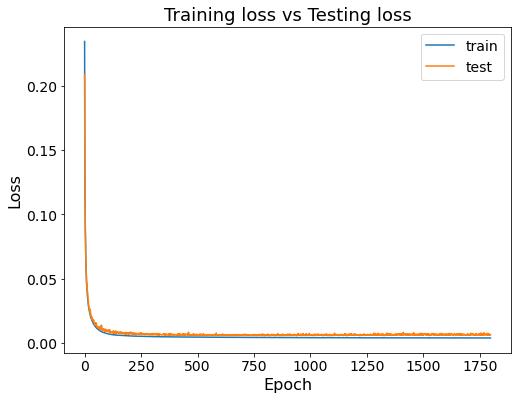

In [69]:
lr = 5e-4
EPOCHS = 6000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


energy_pararcnn.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/energy_cnn_sc1_4layer_{}h_no_sc.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = energy_pararcnn.fit(train_X, train_y,
                              batch_size=512,
                              epochs=EPOCHS,
                              validation_data=(test_X, test_y),
                              verbose=2,
                              shuffle=True,
                              callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [70]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/energy_cnn_sc1_4layer_{}h_no_sc.h5'.format(K))

In [71]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (6994, 24) (6994, 24)
(6994, 24)


In [72]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 3.857
RMSE = 5.095
